In [1]:
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import KFold;
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.tools.plotting import scatter_matrix


C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df = pd.read_csv(r'D:\Documents\ML\Uber\NYPD_Motor_Vehicle_Collisions.csv')

In [19]:
df.head(10)

,DATE,TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,Date/Time,DayOfWeekNum,DayOfWeek,MonthDayNum,HourOfDay
0,02/06/2018,0:00,BRONX,10460,40.834915,-73.894135,"(40.834915, -73.894135)",BOSTON ROAD,WILKENS AVENUE,NaN,...,PASSENGER VEHICLE,SPORT UTILITY / STATION WAGON,NaN,NaN,NaN,2018-02-06,1,Tuesday,6,0
1,02/06/2018,0:00,BRONX,10460,40.835773,-73.893074,"(40.835773, -73.893074)",NaN,NaN,1601 CHARLOTTE STREET,...,SPORT UTILITY / STATION WAGON,SPORT UTILITY / STATION WAGON,NaN,NaN,NaN,2018-02-06,1,Tuesday,6,0
2,02/06/2018,0:00,BRONX,10463,40.878723,-73.916824,"(40.878723, -73.916824)",NaN,NaN,568 KAPPOCK STREET,...,PASSENGER VEHICLE,SPORT UTILITY / STATION WAGON,NaN,NaN,NaN,2018-02-06,1,Tuesday,6,0
3,02/06/2018,0:00,BROOKLYN,11213,40.667892,-73.936770,"(40.667892, -73.93677)",NaN,NaN,311 TROY AVENUE,...,SPORT UTILITY / STATION WAGON,PASSENGER VEHICLE,NaN,NaN,NaN,2018-02-06,1,Tuesday,6,0
4,02/06/2018,0:00,QUEENS,11361,40.757760,-73.783400,"(40.75776, -73.7834)",NORTHERN BOULEVARD,FRANCIS LEWIS BOULEVARD,NaN,...,SPORT UTILITY / STATION WAGON,PASSENGER VEHICLE,NaN,NaN,NaN,2018-02-06,1,Tuesday,6,0
5,02/06/2018,0:00,QUEENS,11366,40.719950,-73.808900,"(40.71995, -73.8089)",NaN,NaN,158-02 UNION TURNPIKE,...,SPORT UTILITY / STATION WAGON,PASSENGER VEHICLE,NaN,NaN,NaN,2018-02-06,1,Tuesday,6,0
6,02/06/2018,0:00,QUEENS,11433,40.702473,-73.799930,"(40.702473, -73.79993)",PARSONS BOULEVARD,ARCHER AVENUE,NaN,...,PASSENGER VEHICLE,NaN,NaN,NaN,NaN,2018-02-06,1,Tuesday,6,0
7,02/06/2018,0:00,QUEENS,11433,40.704860,-73.784130,"(40.70486, -73.78413)",NaN,NaN,175-16 LIBERTY AVENUE,...,TK,PASSENGER VEHICLE,NaN,NaN,NaN,2018-02-06,1,Tuesday,6,0
8,02/06/2018,0:00,NaN,NaN,40.699930,-73.961880,"(40.69993, -73.96188)",BROOKLYN QUEENS EXPRESSWAY,NaN,NaN,...,PICK-UP TRUCK,NaN,NaN,NaN,NaN,2018-02-06,1,Tuesday,6,0
9,02/06/2018,0:00,NaN,NaN,40.681137,-73.955670,"(40.681137, -73.95567)",FULTON STREET,NaN,NaN,...,PASSENGER VEHICLE,SPORT UTILITY / STATION WAGON,NaN,NaN,NaN,2018-02-06,1,Tuesday,6,0


In [60]:
from matplotlib import cm
color = cm.inferno_r(np.linspace(.4,.8, 30))

In [10]:
df['Date/Time'].sample(10)

391468      05/25/2016 7:37
88347       09/18/2017 7:00
266003     12/06/2016 21:15
917444     12/03/2013 10:45
1028277    05/24/2013 17:00
256514     12/20/2016 13:25
985079     08/06/2013 16:40
914011     12/09/2013 12:40
12887      01/14/2018 20:40
184179     04/24/2017 12:18
Name: Date/Time, dtype: object

In [12]:
df['Date/Time'] = pd.to_datetime(df['Date/Time'], format="%m/%d/%Y %H:%M")
df['DayOfWeekNum'] = df['Date/Time'].dt.dayofweek
df['DayOfWeek'] = df['Date/Time'].dt.weekday_name
df['MonthDayNum'] = df['Date/Time'].dt.day
df['HourOfDay'] = df['Date/Time'].dt.hour

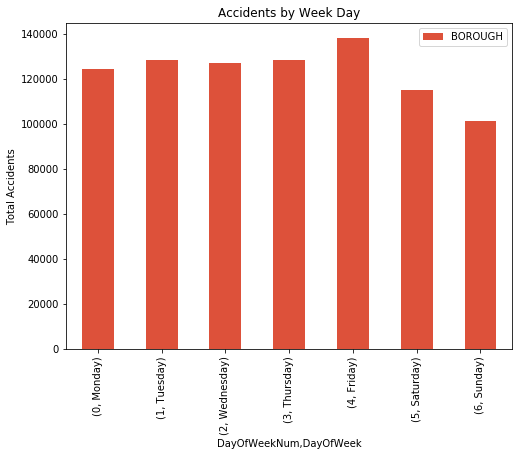

In [61]:
df_weekdays = df.pivot_table(index=['DayOfWeekNum','DayOfWeek'],
                                    values = 'BOROUGH',
                                  aggfunc='count')
df_weekdays.plot(kind='bar', figsize=(8,6),stacked=True, color=color)
plt.ylabel('Total Accidents')
plt.title('Accidents by Week Day');

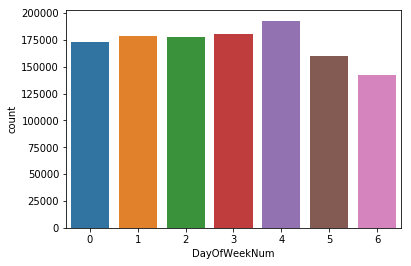

In [18]:
ax = sns.countplot(x="DayOfWeekNum", data=df)

In [38]:
df_copy = df[(df['Year']==2014) | (df['Year']==2015)]

In [40]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 423678 entries, 398598 to 901659
Data columns (total 35 columns):
DATE                             423678 non-null object
TIME                             423678 non-null object
BOROUGH                          319778 non-null object
ZIP CODE                         319756 non-null object
LATITUDE                         355646 non-null float64
LONGITUDE                        355646 non-null float64
LOCATION                         355646 non-null object
ON STREET NAME                   359571 non-null object
CROSS STREET NAME                359551 non-null object
OFF STREET NAME                  14318 non-null object
NUMBER OF PERSONS INJURED        423678 non-null int64
NUMBER OF PERSONS KILLED         423678 non-null int64
NUMBER OF PEDESTRIANS INJURED    423678 non-null int64
NUMBER OF PEDESTRIANS KILLED     423678 non-null int64
NUMBER OF CYCLIST INJURED        423678 non-null int64
NUMBER OF CYCLIST KILLED         423678 non-null

In [41]:
df_copy['NUMBER OF PERSONS INJURED'].sample(10)

871710    1
759629    1
877475    0
743989    0
855130    0
610605    0
666540    0
866204    4
513735    0
841111    0
Name: NUMBER OF PERSONS INJURED, dtype: int64

In [43]:
df_copy.groupby(['DayOfWeekNum'])['NUMBER OF PERSONS INJURED'].mean()

DayOfWeekNum
0    0.250562
1    0.245557
2    0.245613
3    0.243704
4    0.247440
5    0.276841
6    0.295919
Name: NUMBER OF PERSONS INJURED, dtype: float64

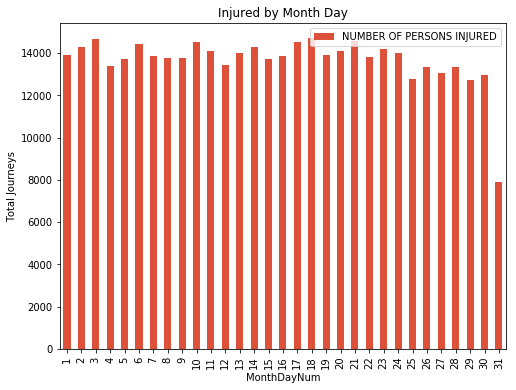

In [63]:
df_copy_monthdays = df_copy.pivot_table(index=['MonthDayNum'],
                                  values='NUMBER OF PERSONS INJURED',
                                  aggfunc='count')
df_copy_monthdays.plot(kind='bar', figsize=(8,6), color=color)
plt.ylabel('Total Journeys')
plt.title('Injured by Month Day');

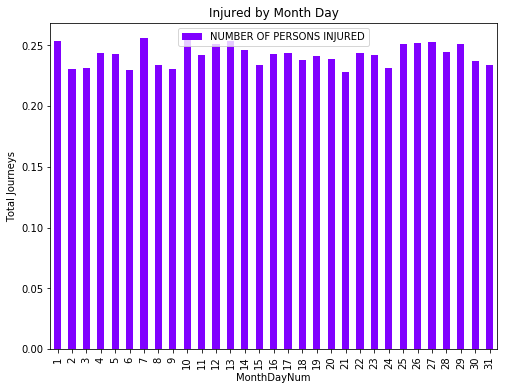

In [72]:
df_copy_monthdays = df_copy.pivot_table(index=['MonthDayNum'],
                                  values='NUMBER OF PERSONS INJURED',
                                  aggfunc='mean')
df_copy_monthdays.plot(kind='bar', figsize=(8,6),colormap = 'rainbow')
plt.ylabel('Total Journeys')
plt.title('Injured by Month Day');

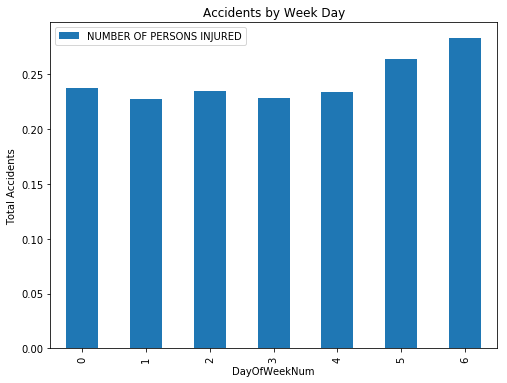

In [56]:
df_copy_weekdays = df_copy.pivot_table(index=['DayOfWeekNum'],
                                    values = 'NUMBER OF PERSONS INJURED',
                                  aggfunc='mean')
df_copy_weekdays.plot(kind='bar', figsize=(8,6))
plt.ylabel('Total Accidents')
plt.title('Accidents by Week Day');

In [80]:
west, south, east, north = -74.26, 40.50, -73.70, 40.92
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mpl_toolkits
from mpl_toolkits.basemap import Basemap
from matplotlib import cm
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111)
m = Basemap(projection='merc', llcrnrlat=south, urcrnrlat=north,
            llcrnrlon=west, urcrnrlon=east, lat_ts=south, resolution='i')
x, y = m(df_copy['LONTITUDE'].values, df_copy['LATITUDE'].values)
m.hexbin(x, y, gridsize=1000,
         bins='log', cmap=cm.YlOrRd_r);

ModuleNotFoundError: No module named 'mpl_toolkits.basemap'

In [78]:
df_copy.to_csv(r'D:\Documents\ML\Uber\collision_20142015.csv')

In [82]:
import mpl_toolkits
from mpl_toolkits.basemap import Basemap

ModuleNotFoundError: No module named 'mpl_toolkits.basemap'